Current and near-term quantum computers suffer from imperfections, as we repeatedly pointed it out. This is why we cannot run long algorithms, that is, deep circuits on them. A new breed of algorithms started to appear since 2013 that focus on getting an advantage from imperfect quantum computers. The basic idea is extremely simple: run a short sequence of gates where some gates are parametrized. Then read out the result, make adjustments to the parameters on a classical computer, and repeat the calculation with the new parameters on the quantum hardware. This way we create an iterative loop between the quantum and the classical processing units, creating classical-quantum hybrid algorithms.


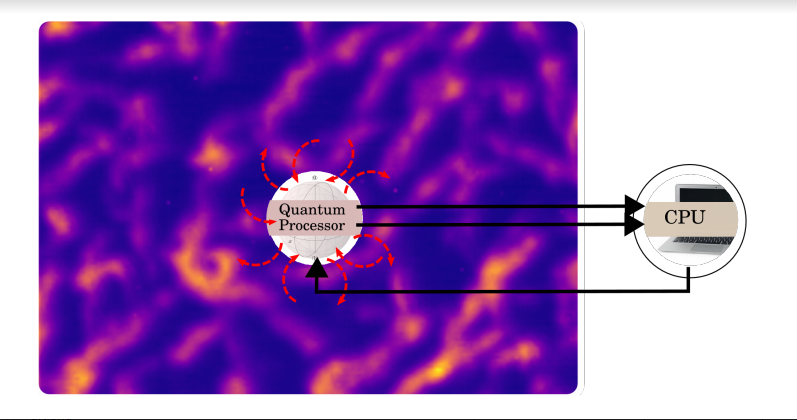<img src="images/hybrid_classical_quantum.svg" alt="Hybrid classical-quantum paradigm" style="width: 400px;"/>

These algorithms are also called variational to reflect the variational approach to changing the parameters. One of the most important example of this approach is the quantum approximate optimization algorithm, which is the subject of this notebook.

# Quantum approximate optimization algorithm

The quantum approximate optimization algorithm (QAOA) is a shallow-circuit variational algorithm for gate-model quantum computers that was inspired by quantum annealing. We discretize the adiabatic pathway in some $p$ steps, where $p$ influences precision. Each discrete time step $i$ has two parameters, $\beta_i, \gamma_i$. The classical variational algorithms does an optimization over these parameters based on the observed energy at the end of a run on the quantum hardware.

More formally, we want to discretize the time-dependent $H(t)=(1-t)H_0 + tH_1$ under adiabatic conditions. We achieve this by Trotterizing the unitary. For instance, for time step $t_0$, we can split this unitary as $U(t_0) = U(H_0, \beta_0)U(H_1, \gamma_0)$. We can continue doing this for subsequent time steps, eventually splitting up the evolution to $p$ such chunks:

$$
U = U(H_0, \beta_0)U(H_1, \gamma_0)\ldots U(H_0, \beta_p)U(H_1, \gamma_p).
$$

At the end of optimizing the parameters, this discretized evolution will approximate the adiabatic pathway:

<img src="images/qaoa_process.svg" alt="Quantum approximate optimization algorithm" style="width: 400px;"/>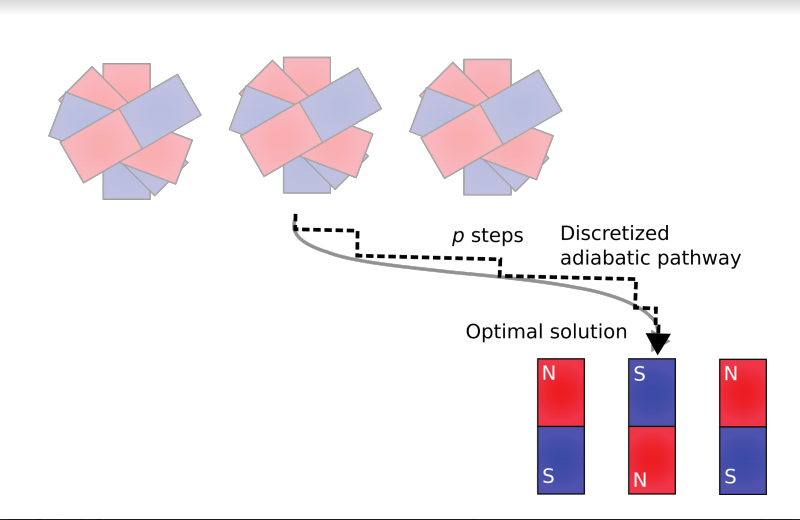

The Hamiltonian $H_0$ is often referred to as the driving or mixing Hamiltonian, and $H_1$ as the cost Hamiltonian. The simplest mixing Hamiltonian is $H_0 = -\sum_i \sigma^X_i$, the same as the initial Hamiltonian in quantum annealing. By alternating between the two Hamiltonian, the mixing Hamiltonian drives the state towards an equal superposition, whereas the cost Hamiltonian tries to seek its own ground state.

In this notebook we go over the quantum approximate optimization algorithm (QAOA) and get acquainted with Qiskit Aqua (the documentation can be found [here](https://qiskit.org/documentation/apidoc/aqua/aqua.html). Documentation of Qiskit Aqua operators is [here](https://qiskit.org/documentation/apidoc/aqua/operators/operators.html)). 

Let us import the necessary packages first:

In [1]:
import itertools
import numpy as np
from qiskit import Aer, QuantumRegister, QuantumCircuit, execute
from qiskit.quantum_info import Pauli, Operator
from qiskit.aqua import get_aer_backend
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from scipy.optimize import minimize
np.set_printoptions(precision=3, suppress=True)

Now we can define our mixing Hamiltonian on some qubits. We need to define, for instance, an `IZ` operator to express $\mathbb{I}\otimes\sigma_1^Z$, that is, the $\sigma_1^Z$ operator acting only on qubit 1. We can achieve the same effect the following way (this time using the Pauli-X operator):

In Qiskit, Pauli matrices can be instantiated using the class `Pauli`. This class takes two parameters, the first for $\sigma^Z$ and the second for $\sigma^X$. Each parameter is a binary vector of dimension `n_qubits`, such that the component $i$ is 1 if you want a Pauli matrix to apply on the $i^{th}$ qubit and 0 otherwise. For instance, $\sigma_1^Z \otimes \sigma_3^Z \otimes \sigma_1^X$ would be implemented using `Pauli([1,0,1],[1,0,0])`.

In order to build Hamiltonians and make them evolve (i.e. exponentiate them, as required in QAOA), we need to use the class `Operator` from Qiskit Aqua. This class constructs a Hamiltonian as a sum of products of Pauli matrices. It takes an array of size $n \times 2$ as parameter, such that each row corresponds to a term in the sum and each term has two components: a coefficient and a `Pauli` object. For instance, $3 \sigma^Z_1 + 2 \sigma^X_3$ would be written `Operator([[3, Pauli([1,0,0], [0,0,0])], [2, Pauli([0,0,0],[0,0,1])]])`.  

**Exercise 1:** Let us denote by `n_qubits` the number of qubits in the circuit. To simplify the code, let's build a function `pauli_x` that simply takes a qubit index (`qubit_index`) and a coefficient and returns the corresponding X-Pauli matrix as an `WeightedPauliOperator`. This operator will act trivially on all qubits, except the given one, i.e. a $\sigma^X$ is applied to the qubit at the given index, and identity to the rest.

In [2]:
def pauli_x(n_qubits, qubit_index, coeff):
    #YOUR CODE HERE
    I = np.eye(n_qubits)
    Paul = Pauli(np.zeros(n_qubits), I[qubit_index])
    return WeightedPauliOperator([[coeff, Paul]])

The coefficient here corresponds to the strength of the transverse field at the given qubit. Let's define the mixing Hamiltonian over two qubits:

In [3]:
n_qubits = 2
identity = pauli_x(n_qubits, 0, 0)

Hm = sum([pauli_x(n_qubits, i, -1) for i in range(n_qubits)], identity)

In [4]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

As an example, we will minimize the Ising problem defined by the cost Hamiltonian $H_c=-\sigma^Z_1 \otimes \sigma^Z_2$. First let's create the functions defining the operators using the Pauli-Z matrix:

**Exercise 2:** build a function `pauli_x` that simply takes a qubit index (`qubit_index`) and a coefficient and returns the corresponding Z-Pauli matrix as an `WeightedPauliOperator` (analog of the function pauli_x)

In [5]:
def pauli_z(n_qubits, qubit_index, coeff):
    #YOUR CODE HERE
    I = np.eye(n_qubits)
    Paul = Pauli(I[qubit_index], np.zeros(n_qubits))
    return WeightedPauliOperator([[coeff, Paul]])

**Exercise 3:** In order to construct the cost Hamiltonian, we need to build a `WeightedPauliOperator` object which is a multiplication of two `Pauli` objects (each applied to a qubit at different indices). The `Pauli` objects in Qiskit Aqua support multiplication with asterisk. Build a function which returns a `WeightedPauliOperator` object representing the multiplication of two Pauli objects acting on qubits `q1` and `q2` with an overall coefficient.

In [6]:
def product_pauli_z(q1, q2, coeff):
    #YOUR CODE HERE
    I = np.eye(n_qubits)
    Paul = Pauli(I[q1], np.zeros(n_qubits)) * Pauli(I[q2], np.zeros(n_qubits))
    return WeightedPauliOperator([[coeff, Paul]])

Then we define the cost Hamiltonian:

In [7]:
J = np.array([[0,1],[0,0]])
Hc = sum([product_pauli_z(i, j, -J[i,j]) for i,j in itertools.product(range(n_qubits), repeat=2)], identity)

We set the number of time evolution steps $p=1$ and initialize the $\beta_i$ and $\gamma_i$ parameters randomly:

In [8]:
p = 1
beta = np.random.uniform(0, np.pi*2, p)
gamma = np.random.uniform(0, np.pi*2, p)

**Exercise 4:** The initial state for the algorithm is a uniform superposition of all the states $|q_1,...,q_n\rangle$. Create a quantum circuit called `circuit_init` with a quantum register containing `n_qubits` qubits, and initialize the register in a uniform superposition state

In [9]:
#YOUR CODE HERE
qr = QuantumRegister(n_qubits)
circuit_init = QuantumCircuit(qr)

for qubit in range(n_qubits):
    circuit_init.h(qubit)

Now we define a function `evolve` that takes a Hamiltonian $H$ and an angle $t$ and returns a quantum circuit component made of the unitary matrix $e^{i H t}$. For that, we use the method [`evolve`](https://qiskit.org/documentation/apidoc/aqua/operators/operators.html#qiskit.aqua.operators.WeightedPauliOperator.evolve) of the class `WeightedPauliOperator`. The arguments are:
* **initial circuit**: if we want to build $e^{iHt} |\psi\rangle$ with $|\psi\rangle$ an initial state. Set to `None` if we just need $e^{iHt}$, as in our case (we will append the initial circuit built above only at the end, not between all the exponentials).
* **angle**: the parameter t in $e^{iHt}$
* **type** of the returned object: in our case, we want a 'circuit'
* **quantum registers**: quantum register
* **expansion_mode**: method used to compute the evolution
* **expansion_order**: order of the approximation used for computing the evolution

In [10]:
def evolve(hamiltonian, angle, qr):
    return hamiltonian.evolve(state_in=None, 
                              evo_time=angle, 
                              num_time_slices=1,
                              quantum_registers=qr,
                              expansion_mode='trotter',
                              expansion_order=3)

To create the circuit, we need to compose the different unitary matrice given by `evolve`.

In [11]:
def create_circuit(beta, gamma):
    circuit_evolv = sum([evolve(Hc, beta[i], qr) + evolve(Hm, gamma[i], qr) for i in range(p)], 
                         circuit_init)
    
    return circuit_evolv

We now create a function `evaluate_circuit` that takes a single vector `gamma_beta` (the concatenation of `gamma` and `beta`) and returns $\langle H_c \rangle = \langle \psi | H_c | \psi \rangle$ where $\psi$ is defined by the circuit created with the function above.

**Exercise 5:** Using the evaluation methods available for the `WeightedPauliOperator` objects compute $\langle \psi | H_c | \psi\rangle$. You need to 1. obtain a quantum circuit for evaluation based on the operator, 2. execute it against an Aer backend 3. evaluate the mean value of the hamiltonian based on the execution results.

In [12]:
def evaluate_circuit(beta_gamma):
    #YOUR CODE HERE
    beta, gamma = beta_gamma
    cr_circuit = create_circuit([beta], [gamma])
    
    H_c = Hc.construct_evaluation_circuit(cr_circuit, True, qr)
    backend = Aer.get_backend('statevector_simulator')
    run = execute(H_c, backend)
    
    results = np.real(Hc.evaluate_with_result(run.result(), True))
    return results

Finally, we optimize the angles with a classical optimization procedure:

In [13]:
result = minimize(evaluate_circuit, np.concatenate([beta, gamma]), method='COBYLA') #'L-BFGS-B'
result 

     fun: -0.9999999227924452
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 41
  status: 1
 success: True
       x: array([0.786, 1.964])

# Analysis of the results

We create a circuit using the optimal parameters found.

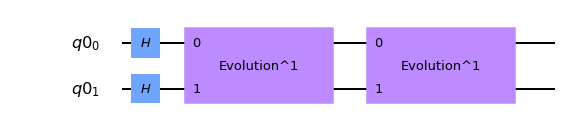

In [14]:
circuit = create_circuit(result['x'][:p], result['x'][p:])
circuit.draw(output='mpl')

We use the `statevector_simulator` backend in order to display the state created by the circuit.

In [15]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
state = np.asarray(job.result().get_statevector(circuit))
print(np.absolute(state))
print(np.angle(state))

[0.707 0.    0.    0.707]
[ 3.141 -0.655 -0.655  3.141]


We see that the state is approximately $\frac{1}{\sqrt{2}} \left( |00 \rangle + |11 \rangle \right)$. It corresponds to a uniform superposition of the two solutions of the classicial problem: $(\sigma_1=1$, $\sigma_2=1)$ and $(\sigma_1=-1$, $\sigma_2=-1)$

We see that both are approximatively equal to zero. It's expected given the state we found above and corresponds a typical quantum behavior where $\mathbb{E}[\sigma^Z_1 \sigma^Z_2] \neq \mathbb{E}[\sigma^Z_1] \mathbb{E}[\sigma^Z_2]$